In [1]:
%matplotlib inline

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [3]:
inputPath = '/data2/niznik/dlVars_3D/'
uInputFile = inputPath+'U_r90x45.nc4'
vInputFile = inputPath+'V_r90x45.nc4'
wInputFile = inputPath+'W_r90x45.nc4'
wuwvInputFile = '/data2/suvarchal/G5NR/wv_and_wu_4deg.nc4'
TInputFile = '/data2/suvarchal/G5NR/T_r90x45_1time.nc4'

In [38]:
#uvw_da=xr.open_mfdataset([uInputFile,vInputFile,wInputFile,wuwvInputFile]) #not used but should be more efficient

In [5]:
u_da=xr.open_dataset(uInputFile,chunks={'time':100})
v_da=xr.open_dataset(vInputFile,chunks={'time':100})
w_da=xr.open_dataset(wInputFile,chunks={'time':100})
wuwv_da=xr.open_dataset(wuwvInputFile,chunks={'time':100})
T_da=xr.open_dataset(TInputFile)

In [55]:
u = u_da['U'][0:2,:,:,:]
v = v_da['V'][0:2,:,:,:]
w = w_da['W'][0:2,:,:,:]
wu = wuwv_da['WU'][0:2,:,:,:]
wv = wuwv_da['WV'][0:2,:,:,:]

In [6]:
P=u_da.lev*100.0 #convert Pressure to Pa and is ordered top down

In [7]:
dPbyg=np.gradient(P)/9.8
dPbyg=xr.DataArray(dPbyg,coords={'lev':u_da.lev})

In [8]:
rho=(1/(T_da['T'][0,:,:,:]*287.06))*P #kg/m3 #checked by plotting rho[47,:,:].plot.contourf()

In [59]:
Eddy_Flux_Zon = (wu - u*w)*rho
Eddy_Flux_Mer = (wv - v*w)*rho
Eddy_Flux_Zon.name='Eddy_Flux_Zon'
Eddy_Flux_Mer.name='Eddy_Flux_Mer'
#make it a dataset for easy function application on all variables 
Eddy_Flux=xr.merge([Eddy_Flux_Zon,Eddy_Flux_Mer]) 

In [60]:
axisint=1 if len(np.shape(Eddy_Flux_Zon))>3 else 0
Eddy_Flux_Tend=Eddy_Flux.apply(np.gradient,axis=axisint)
Eddy_Flux_Tend=Eddy_Flux_Tend/dPbyg

In [61]:
u_baro=(rho*u).sum(dim='lev')/rho.sum(dim='lev')
v_baro=(rho*v).sum(dim='lev')/rho.sum(dim='lev')

In [62]:
ushear=u-u_baro
vshear=v-v_baro #checked for handling of missing values
SKE=ushear*ushear+vshear*vshear
SKE=SKE.sum(dim='lev')/rho.sum(dim='lev')
SKE.name='SKE'
SKE.attrs={'long_name':'SKE','units':'J Kg^-1'}

In [63]:
SKEDOT=(Eddy_Flux['Eddy_Flux_Zon']*ushear/dPbyg + Eddy_Flux['Eddy_Flux_Mer']*vshear/dPbyg).sum(dim='lev')
SKEDOT.name='SKEDOT'
SKEDOT.attrs={'long_name':'dp/g Integral(-d/dp([uw]-[u][w])*u_shear - d/dp([vw]-[v][w])*v_shear)','units':'W m-2'}
#SKEDOT.plot.contourf() checked

In [64]:
KEDOT=(Eddy_Flux['Eddy_Flux_Zon']*u/dPbyg + Eddy_Flux['Eddy_Flux_Mer']*v/dPbyg).sum(dim='lev')
KEDOT.name='KEDOT'
KEDOT.attrs={'long_name':'Integral(-d/dp([uw]-[u][w])*u - d/dp([vw]-[v][w])*v)','units':'W m-2'}

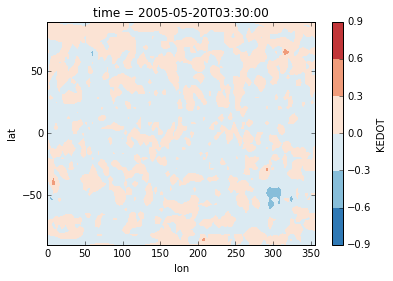

In [65]:
KEDOT[99,:,:].plot.contourf()

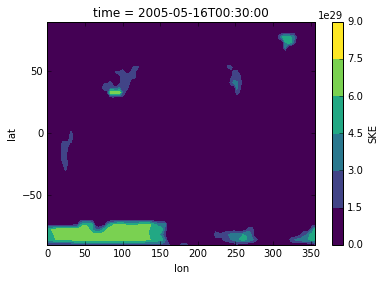

In [41]:
skeoldfile.SKE[0,:,:].plot.contourf(title='SKEOLD')

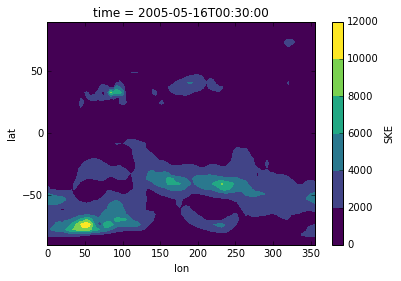

In [37]:
SKE.plot.contourf()

In [12]:
start=[i*1000 for i in xrange(len(u_da.time)/1000,1000) if i*1000<len(u_da.time)]

In [10]:
import itertools
import datetime
t1=datetime.datetime.now()

In [11]:
t1=datetime.datetime.now()
for start,stop in itertools.izip(range(len(u_da.time))[0::1000],range(len(u_da.time))[1000::1000]+[len(u_da.time)]):
    u = u_da['U'][start:stop,:,:,:]
    v = v_da['V'][start:stop,:,:,:]
    w = w_da['W'][start:stop,:,:,:]
    wu = wuwv_da['WU'][start:stop,:,:,:]
    wv = wuwv_da['WV'][start:stop,:,:,:]
    
    Eddy_Flux_Zon = (wu - u*w)*rho
    Eddy_Flux_Mer = (wv - v*w)*rho
    Eddy_Flux_Zon.name='Eddy_Flux_Zon'
    Eddy_Flux_Mer.name='Eddy_Flux_Mer'
    Eddy_Flux=xr.merge([Eddy_Flux_Zon,Eddy_Flux_Mer]) 
    axisint=1
    Eddy_Flux_Tend=Eddy_Flux.apply(np.gradient,axis=axisint)
    Eddy_Flux_Tend=Eddy_Flux_Tend/dPbyg
    u_baro=(rho*u).sum(dim='lev')/rho.sum(dim='lev')
    v_baro=(rho*v).sum(dim='lev')/rho.sum(dim='lev')
    ushear=u-u_baro
    vshear=v-v_baro #checked for handling of missing values
    SKE=ushear*ushear+vshear*vshear
    SKE=SKE.sum(dim='lev')/rho.sum(dim='lev')
    SKE.name='SKE'
    SKE.attrs={'long_name':'SKE','units':'J Kg^-1'}
    SKEDOT=(Eddy_Flux['Eddy_Flux_Zon']*ushear/dPbyg + Eddy_Flux['Eddy_Flux_Mer']*vshear/dPbyg).sum(dim='lev')
    SKEDOT.name='SKEDOT'
    SKEDOT.attrs={'long_name':'dp/g Integral(-d/dp([uw]-[u][w])*u_shear - d/dp([vw]-[v][w])*v_shear)','units':'W m-2'}
    KEDOT=(Eddy_Flux['Eddy_Flux_Zon']*u/dPbyg + Eddy_Flux['Eddy_Flux_Mer']*v/dPbyg).sum(dim='lev')
    KEDOT.name='KEDOT'
    KEDOT.attrs={'long_name':'Integral(-d/dp([uw]-[u][w])*u - d/dp([vw]-[v][w])*v)','units':'W m-2'}
    xr.merge([KEDOT,SKEDOT,SKE]).to_netcdf('/data2/suvarchal/G5NR/SKE_testX_'+str(format(start,'05'))+'.nc')
    print "end of "+str(start)+" time elapsed "+str((datetime.datetime.now()-t1).total_seconds())

end of 0 time elapsed 364.618628
end of 1000 time elapsed 628.834319
end of 2000 time elapsed 909.069966
end of 3000 time elapsed 1219.436785
end of 4000 time elapsed 1539.732608
end of 5000 time elapsed 1989.028938
end of 6000 time elapsed 2202.287205
end of 7000 time elapsed 2661.985895
end of 8000 time elapsed 3379.700148
end of 9000 time elapsed 4156.871724
end of 10000 time elapsed 4723.012475
end of 11000 time elapsed 4916.266024
end of 12000 time elapsed 5033.807868
end of 13000 time elapsed 5143.888758
end of 14000 time elapsed 5258.264331
end of 15000 time elapsed 5375.97191
end of 16000 time elapsed 5539.89905
end of 17000 time elapsed 5726.26896
end of 18000 time elapsed 5792.787086
